In [1]:
## this notebook will deteck anomalies from the pcap outputs.

import pandas as pd
import numpy as np

from torch import nn

import scipy
import matplotlib.pyplot as plt
import seaborn as sns


from data_extractors import advanced_process, basic_process

import os
import sys

##install pytorch

##install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest
## train test split import with cross fold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [ ]:
current_wd = os.getcwd()

three_days_advanced_raw = advanced_process(f"{current_wd}/pcap-files","four_days_adv.csv") ## this will likely cause errors now because the package is still getting collected in the background.

three_days_basic_raw = basic_process(f"{current_wd}/pcap-files","four_days_basic.csv") 


adv_df = pd.read_csv(three_days_advanced_raw)
basic_df = pd.read_csv(three_days_basic_raw)

Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day4.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day3.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day2.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day1.pcap...
Successfully extracted features from 210 time windows
Data saved to three_days_adv.csv
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day4.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day3.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day2.pcap...
Processing /Users/eren/Documents/GitHub/Network-Anomaly-Detection/pcap-files/baseline_day1.pcap...
Successfully extracted features from 211 time windows
Data saved to three_days_basic.csv


In [15]:
import pandas as pd
import scipy.stats

def get_stats(dataframe=pd.DataFrame()):
    """
    This function returns the statistics of the given dataframe.

    Parameters:
    dataframe: pd.DataFrame
        The dataframe to be analyzed.
    """
    try:
        display("--------------------")
        display("dataframe's shape is :")
        display(dataframe.shape)
        display("--------------------")
        display("dataframe's columns are :")
        display(dataframe.columns)
        display("--------------------")
        display("dataframe's info is :")
        display(dataframe.info())
        display("--------------------")
        display("dataframe's head is :")
        display(dataframe.head())
        display("--------------------")
        display("dataframe's tail is :")
        display(dataframe.tail())
        display("--------------------")
        display("dataframe's describe is :")
        display(dataframe.describe())
        display("--------------------")
        display("dataframe's null values are :")
        display(dataframe.isnull().sum())
        display("--------------------")
        display("dataframe's unique values are :")
        display(dataframe.nunique())
        display("--------------------")
        display("dataframe's data types are :")
        display(dataframe.dtypes)
        display("--------------------")
        display("dataframe's memory usage is :")
        display(dataframe.memory_usage())
        display("--------------------")

        ## SciPy stats of the dataframe
        display("dataframe's column stats are :")
        
        stats_list = []
        
        for col in dataframe.select_dtypes(include=['number']).columns:  
            stats_list.append({
                "column name": col,
                "skewness": scipy.stats.skew(dataframe[col].dropna()),  # Drop NaN values
                "kurtosis": scipy.stats.kurtosis(dataframe[col].dropna())
            })
        
        framey = pd.DataFrame(stats_list)
        display(framey)
        display("--------------------")

        ## Correlation of the columns
        display("dataframe's numerical correlation is :")
        display(dataframe.corr(numeric_only=True))
        display("--------------------")

        ## Covariance of the columns
        display("dataframe's covariance is :")
        display(dataframe.cov(numeric_only=True))
        display("--------------------")


        ##plotitng every numerical variable's distribution.

        for col in dataframe.select_dtypes(include=["number"]).columns:
            sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)
            plt.show()

    except Exception as e:
        print("An error occurred: ", e)
        return []


'--------------------'

"dataframe's shape is :"

(210, 37)

'--------------------'

"dataframe's columns are :"

Index(['window_id', 'window_start', 'packet_count', 'bytes_per_second',
       'avg_packet_size', 'packet_size_std', 'unique_protocols',
       'unique_src_ips', 'unique_dst_ips', 'unique_src_ports',
       'unique_dst_ports', 'unique_ip_pairs', 'unique_port_pairs',
       'unique_connections', 'dns_query_count', 'bytes_in', 'bytes_out',
       'packets_in', 'packets_out', 'io_bytes_ratio', 'io_packet_ratio',
       'new_connections', 'syn_count', 'fin_count', 'rst_count',
       'syn_fin_ratio', 'connection_termination_ratio', 'retransmission_count',
       'retransmission_rate', 'internal_external_ratio', 'ttl_mean', 'ttl_std',
       'http_get_count', 'http_post_count', 'http_other_count', 'is_baseline',
       'file_source'],
      dtype='object')

'--------------------'

"dataframe's info is :"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   window_id                     210 non-null    int64  
 1   window_start                  210 non-null    int64  
 2   packet_count                  210 non-null    int64  
 3   bytes_per_second              210 non-null    float64
 4   avg_packet_size               210 non-null    float64
 5   packet_size_std               210 non-null    float64
 6   unique_protocols              210 non-null    int64  
 7   unique_src_ips                210 non-null    int64  
 8   unique_dst_ips                210 non-null    int64  
 9   unique_src_ports              210 non-null    int64  
 10  unique_dst_ports              210 non-null    int64  
 11  unique_ip_pairs               210 non-null    int64  
 12  unique_port_pairs             210 non-null    int64  
 13  uniqu

None

'--------------------'

"dataframe's head is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline,file_source
0,29038135,1742288100,1625,13667.266667,504.637538,560.903562,0,27,28,68,...,25,0.015385,0.122449,73.877039,33.603507,0,0,0,True,baseline_day4.pcap
1,29038136,1742288160,12678,158984.050000,752.409134,584.769955,0,51,53,166,...,105,0.008282,0.072165,62.614812,24.685138,1,0,0,True,baseline_day4.pcap
2,29038137,1742288220,3390,37162.116667,657.736578,646.239328,0,36,34,62,...,22,0.006490,0.186441,91.341768,32.891857,0,0,0,True,baseline_day4.pcap
3,29038138,1742288280,2730,22836.666667,501.904762,558.323207,0,32,32,106,...,20,0.007326,0.142857,67.325468,28.122180,0,0,0,True,baseline_day4.pcap
4,29038139,1742288340,702,2291.850000,195.884615,291.221149,0,30,26,55,...,1,0.001425,0.272727,81.205405,58.171424,0,0,0,True,baseline_day4.pcap


'--------------------'

"dataframe's tail is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline,file_source
205,29028315,1741698900,301,811.133333,161.687708,283.243416,0,18,20,28,...,5,0.016611,0.0,58.962585,17.222295,0,0,0,True,baseline_day1.pcap
206,29028316,1741698960,1027,7941.333333,463.953262,532.872552,0,23,26,37,...,1,0.000974,0.0,61.635651,14.445157,0,0,0,True,baseline_day1.pcap
207,29028317,1741699020,300,1498.633333,299.726667,420.982991,0,21,24,34,...,0,0.000000,0.0,64.839465,18.832859,0,0,0,True,baseline_day1.pcap
208,29028318,1741699080,341,1177.633333,207.208211,313.298393,0,19,18,48,...,1,0.002933,0.0,64.265176,29.276854,0,0,0,True,baseline_day1.pcap
209,29028319,1741699140,72,442.166667,368.472222,539.853272,0,11,12,12,...,0,0.000000,0.0,69.958333,19.017855,0,0,0,True,baseline_day1.pcap


'--------------------'

"dataframe's describe is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,syn_fin_ratio,connection_termination_ratio,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count
count,2.100000e+02,2.100000e+02,210.000000,2.100000e+02,210.000000,210.000000,210.0,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.0,210.000000
mean,2.903250e+07,1.741950e+09,4681.571429,6.988204e+04,482.718283,508.239657,0.0,21.795238,23.123810,56.657143,...,1.552209,1.476892,38.147619,0.016097,0.138039,69.924462,31.562686,0.042857,0.0,0.009524
std,3.169123e+03,1.901474e+05,25011.753564,4.409867e+05,238.055179,143.237364,0.0,9.770622,10.177558,38.515970,...,1.410722,1.838238,97.854604,0.020002,0.111047,19.367625,16.589190,0.225358,0.0,0.138013
min,2.902826e+07,1.741696e+09,25.000000,2.988333e+01,71.720000,12.829716,0.0,5.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,50.468531,7.341066,0.000000,0.0,0.000000
25%,2.902831e+07,1.741699e+09,537.750000,2.758700e+03,274.502683,409.039594,0.0,15.250000,16.250000,31.250000,...,0.942724,0.767650,3.000000,0.002762,0.000000,61.370922,19.705843,0.000000,0.0,0.000000
50%,2.903254e+07,1.741952e+09,1039.500000,7.076658e+03,453.970464,545.392625,0.0,20.000000,21.000000,46.000000,...,1.200000,1.069694,11.000000,0.009188,0.144958,65.341587,27.308412,0.000000,0.0,0.000000
75%,2.903425e+07,1.742055e+09,2680.500000,2.460542e+04,664.140256,621.495637,0.0,26.750000,27.750000,68.000000,...,1.770833,1.445853,29.500000,0.021366,0.213745,73.601502,38.782964,0.000000,0.0,0.000000
max,2.903816e+07,1.742290e+09,334264.000000,5.892223e+06,1222.955393,697.456679,0.0,62.000000,63.000000,228.000000,...,10.666667,16.500000,963.000000,0.137509,0.500000,207.021718,87.021807,2.000000,0.0,2.000000


'--------------------'

"dataframe's null values are :"

window_id                       0
window_start                    0
packet_count                    0
bytes_per_second                0
avg_packet_size                 0
packet_size_std                 0
unique_protocols                0
unique_src_ips                  0
unique_dst_ips                  0
unique_src_ports                0
unique_dst_ports                0
unique_ip_pairs                 0
unique_port_pairs               0
unique_connections              0
dns_query_count                 0
bytes_in                        0
bytes_out                       0
packets_in                      0
packets_out                     0
io_bytes_ratio                  0
io_packet_ratio                 0
new_connections                 0
syn_count                       0
fin_count                       0
rst_count                       0
syn_fin_ratio                   0
connection_termination_ratio    0
retransmission_count            0
retransmission_rate             0
internal_exter

'--------------------'

"dataframe's unique values are :"

window_id                       210
window_start                    210
packet_count                    206
bytes_per_second                210
avg_packet_size                 210
packet_size_std                 210
unique_protocols                  1
unique_src_ips                   45
unique_dst_ips                   46
unique_src_ports                 99
unique_dst_ports                 93
unique_ip_pairs                  70
unique_port_pairs               126
unique_connections              123
dns_query_count                  42
bytes_in                        152
bytes_out                       150
packets_in                      146
packets_out                     140
io_bytes_ratio                  150
io_packet_ratio                 149
new_connections                  74
syn_count                        74
fin_count                        64
rst_count                        39
syn_fin_ratio                   142
connection_termination_ratio    151
retransmission_count        

'--------------------'

"dataframe's data types are :"

window_id                         int64
window_start                      int64
packet_count                      int64
bytes_per_second                float64
avg_packet_size                 float64
packet_size_std                 float64
unique_protocols                  int64
unique_src_ips                    int64
unique_dst_ips                    int64
unique_src_ports                  int64
unique_dst_ports                  int64
unique_ip_pairs                   int64
unique_port_pairs                 int64
unique_connections                int64
dns_query_count                   int64
bytes_in                          int64
bytes_out                         int64
packets_in                        int64
packets_out                       int64
io_bytes_ratio                  float64
io_packet_ratio                 float64
new_connections                   int64
syn_count                         int64
fin_count                         int64
rst_count                         int64


'--------------------'

"dataframe's memory usage is :"

Index                            132
window_id                       1680
window_start                    1680
packet_count                    1680
bytes_per_second                1680
avg_packet_size                 1680
packet_size_std                 1680
unique_protocols                1680
unique_src_ips                  1680
unique_dst_ips                  1680
unique_src_ports                1680
unique_dst_ports                1680
unique_ip_pairs                 1680
unique_port_pairs               1680
unique_connections              1680
dns_query_count                 1680
bytes_in                        1680
bytes_out                       1680
packets_in                      1680
packets_out                     1680
io_bytes_ratio                  1680
io_packet_ratio                 1680
new_connections                 1680
syn_count                       1680
fin_count                       1680
rst_count                       1680
syn_fin_ratio                   1680
c

'--------------------'

"dataframe's column stats are :"

,column name,skewness,kurtosis
0,window_id,0.071631,-0.797641
1,window_start,0.071631,-0.797641
2,packet_count,11.538032,144.228324
3,bytes_per_second,11.593058,145.309528
4,avg_packet_size,0.584049,-0.192866
5,packet_size_std,-0.737028,-0.127146
6,unique_protocols,NaN,NaN
7,unique_src_ips,1.162507,1.622035
8,unique_dst_ips,1.123946,1.525602
9,unique_src_ports,1.763024,3.518418


'--------------------'

"dataframe's numerical correlation is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,connection_termination_ratio,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline
window_id,1.000000,1.000000,-0.104361,-0.109642,0.116648,0.165996,NaN,0.293110,0.256084,0.265799,...,-0.207678,0.080694,0.193925,0.699411,0.022969,0.285388,0.133262,NaN,-0.092347,NaN
window_start,1.000000,1.000000,-0.104361,-0.109642,0.116648,0.165996,NaN,0.293110,0.256084,0.265799,...,-0.207678,0.080694,0.193925,0.699411,0.022969,0.285388,0.133262,NaN,-0.092347,NaN
packet_count,-0.104361,-0.104361,1.000000,0.999608,0.326206,0.077699,NaN,0.281542,0.285503,0.411771,...,0.262695,0.827659,-0.074735,-0.126179,0.691627,0.240173,0.024406,NaN,0.013820,NaN
bytes_per_second,-0.109642,-0.109642,0.999608,1.000000,0.321409,0.071566,NaN,0.265271,0.269223,0.393270,...,0.265176,0.824431,-0.074601,-0.125947,0.690136,0.237452,0.022600,NaN,0.005557,NaN
avg_packet_size,0.116648,0.116648,0.326206,0.321409,1.000000,0.820906,NaN,0.479213,0.441252,0.403082,...,-0.019576,0.422042,-0.139793,-0.008970,0.089501,-0.211560,0.229033,NaN,0.049631,NaN
packet_size_std,0.165996,0.165996,0.077699,0.071566,0.820906,1.000000,NaN,0.346801,0.324793,0.265027,...,-0.124289,0.164519,-0.088855,0.062919,-0.088611,-0.215089,0.133825,NaN,0.046668,NaN
unique_protocols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_src_ips,0.293110,0.293110,0.281542,0.265271,0.479213,0.346801,NaN,1.000000,0.980135,0.873866,...,0.037685,0.347296,-0.151811,-0.127269,0.212826,0.174878,0.236515,NaN,0.058225,NaN
unique_dst_ips,0.256084,0.256084,0.285503,0.269223,0.441252,0.324793,NaN,0.980135,1.000000,0.879335,...,0.042854,0.344189,-0.115484,-0.166894,0.211338,0.180685,0.204201,NaN,0.053658,NaN
unique_src_ports,0.265799,0.265799,0.411771,0.393270,0.403082,0.265027,NaN,0.873866,0.879335,1.000000,...,-0.031308,0.461388,-0.050277,-0.098483,0.289330,0.227010,0.212275,NaN,0.088827,NaN


'--------------------'

"dataframe's covariance is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,connection_termination_ratio,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline
window_id,1.004334e+07,6.026006e+08,-8.272234e+06,-1.532288e+08,8.800236e+04,7.535190e+04,0.0,9.075956e+03,8.259721e+03,3.244390e+04,...,-1209.847253,2.502423e+04,12.292377,246.138179,1.409801e+03,1.500375e+04,95.173616,0.0,-40.390977,0.0
window_start,6.026006e+08,3.615604e+10,-4.963341e+08,-9.193728e+09,5.280141e+06,4.521114e+06,0.0,5.445574e+05,4.955833e+05,1.946634e+06,...,-72590.835182,1.501454e+06,737.542595,14768.290724,8.458804e+04,9.002253e+05,5710.416951,0.0,-2423.458647,0.0
packet_count,-8.272234e+06,-4.963341e+08,6.255878e+08,1.102553e+10,1.942291e+06,2.783668e+05,0.0,6.880344e+04,7.267731e+04,3.966800e+05,...,12078.094784,2.025708e+06,-37.388033,-350.461343,3.350367e+05,9.965360e+04,137.563910,0.0,47.707450,0.0
bytes_per_second,-1.532288e+08,-9.193728e+09,1.102553e+10,1.944693e+11,3.374128e+07,4.520515e+06,0.0,1.142977e+06,1.208317e+06,6.679698e+06,...,214961.883779,3.557634e+07,-658.014756,-6167.650323,5.894358e+06,1.737104e+06,2245.969545,0.0,338.238049,0.0
avg_packet_size,8.800236e+04,5.280141e+06,1.942291e+06,3.374128e+07,5.667027e+04,2.799156e+04,0.0,1.114624e+03,1.069075e+03,3.695831e+03,...,-8.566642,9.831384e+03,-0.665622,-0.237114,4.126479e+02,-8.354800e+02,12.287052,0.0,1.630603,0.0
packet_size_std,7.535190e+04,4.521114e+06,2.783668e+05,4.520515e+06,2.799156e+04,2.051694e+04,0.0,4.853538e+02,4.734852e+02,1.462134e+03,...,-32.725836,2.305976e+03,-0.254567,1.000792,-2.458211e+02,-5.110933e+02,4.319820,0.0,0.922566,0.0
unique_protocols,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0
unique_src_ips,9.075956e+03,5.445574e+05,6.880344e+04,1.142977e+06,1.114624e+03,4.853538e+02,0.0,9.546505e+01,9.746566e+01,3.288577e+02,...,0.676851,3.320495e+02,-0.029668,-0.138086,4.027386e+01,2.834536e+01,0.520779,0.0,0.078514,0.0
unique_dst_ips,8.259721e+03,4.955833e+05,7.267731e+04,1.208317e+06,1.069075e+03,4.734852e+02,0.0,9.746566e+01,1.035827e+02,3.446982e+02,...,0.801750,3.427855e+02,-0.023509,-0.188621,4.165794e+01,3.050635e+01,0.468353,0.0,0.075370,0.0
unique_src_ports,3.244390e+04,1.946634e+06,3.966800e+05,6.679698e+06,3.695831e+03,1.462134e+03,0.0,3.288577e+02,3.446982e+02,1.483480e+03,...,-2.216665,1.738955e+03,-0.038732,-0.421221,2.158298e+02,1.450480e+02,1.842515,0.0,0.472180,0.0


'--------------------'

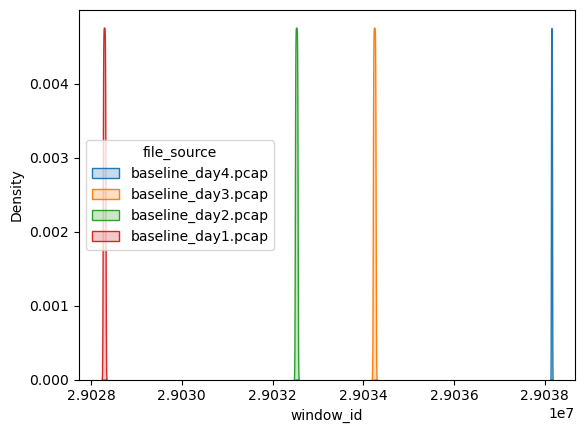

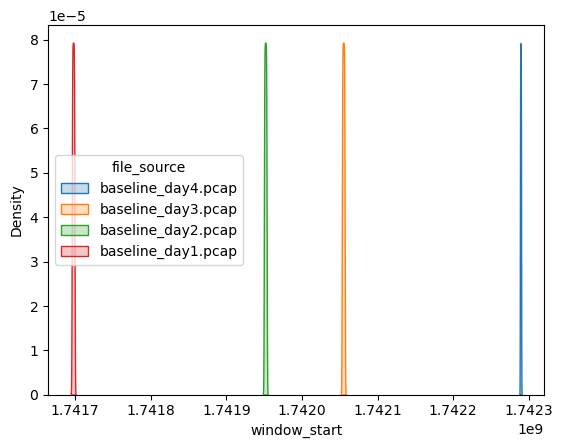

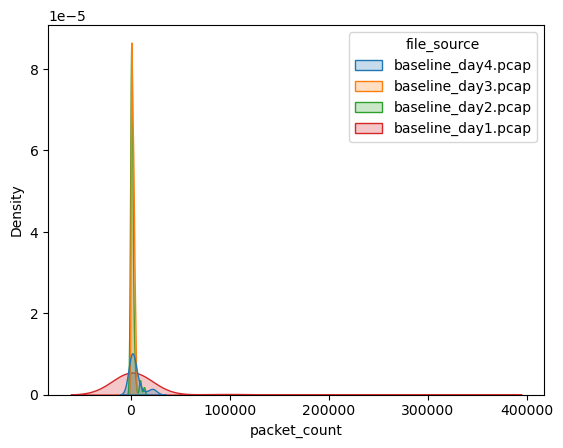

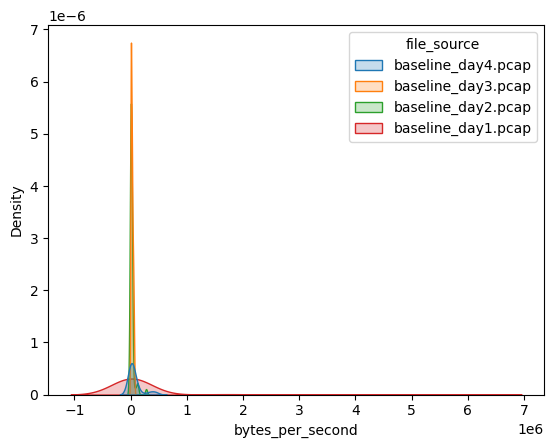

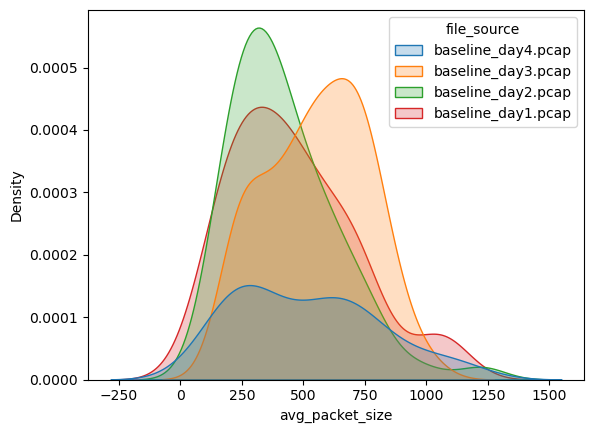

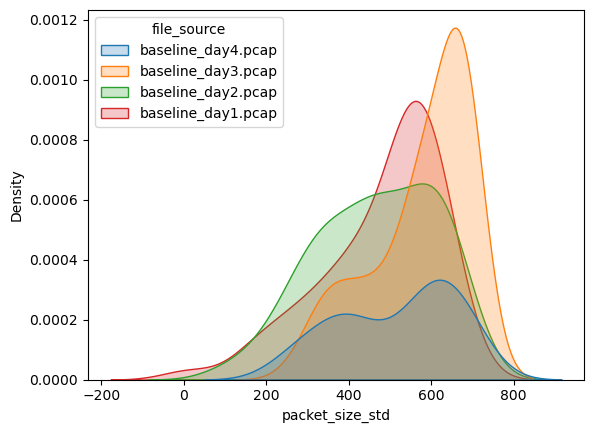

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


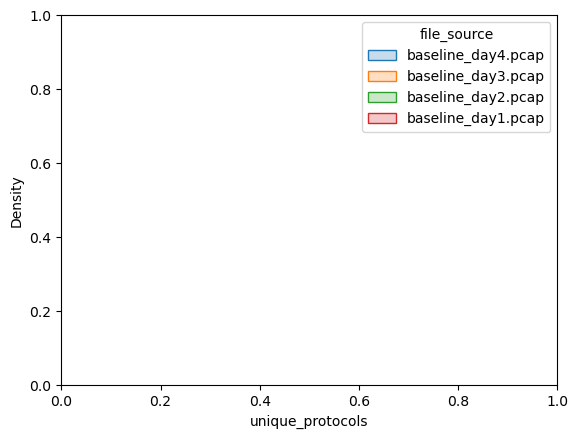

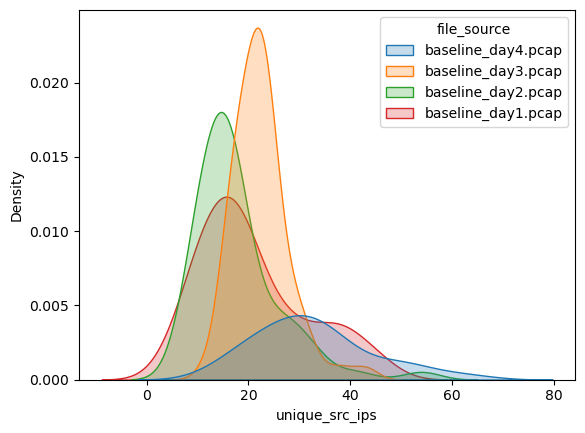

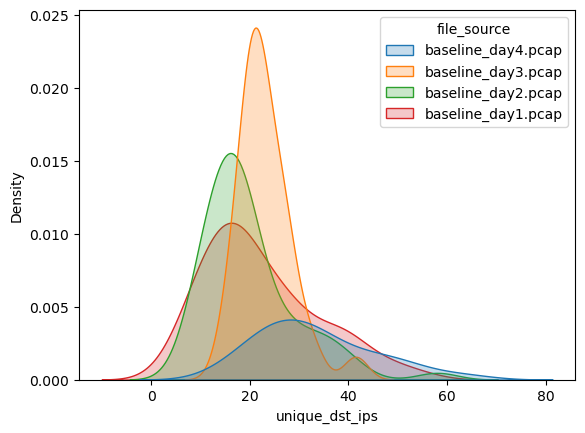

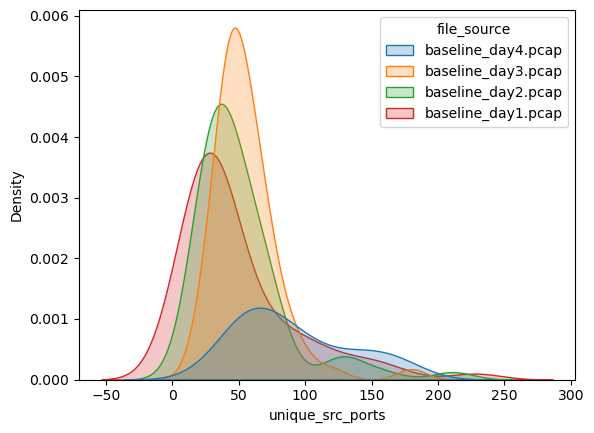

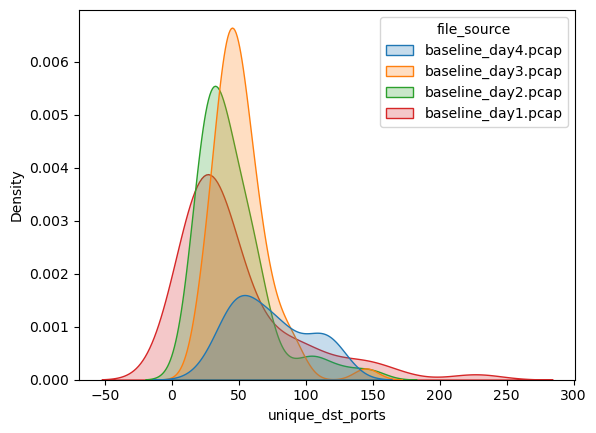

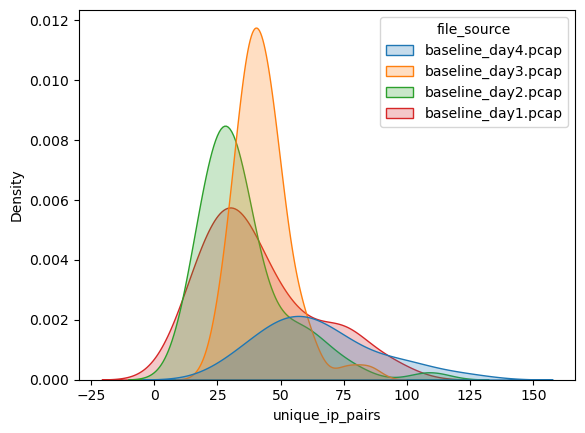

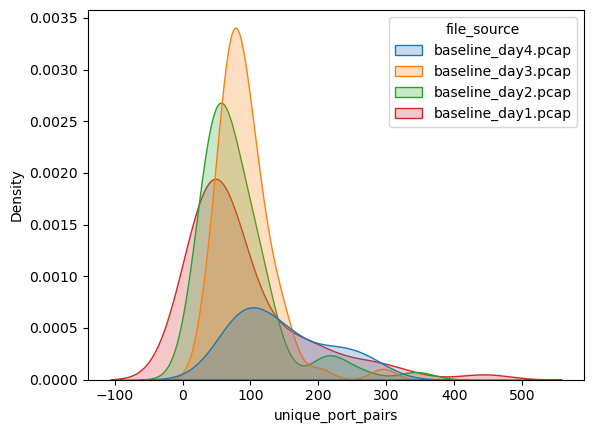

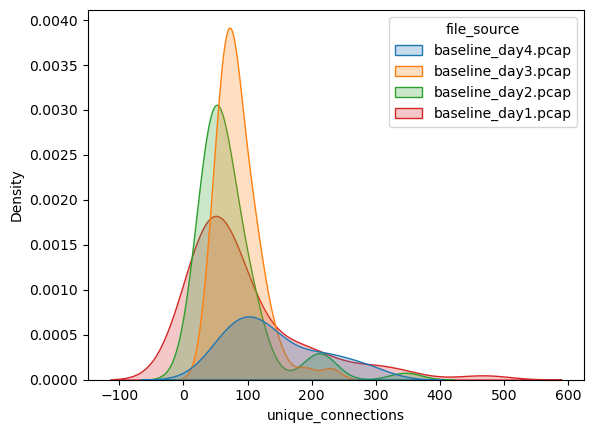

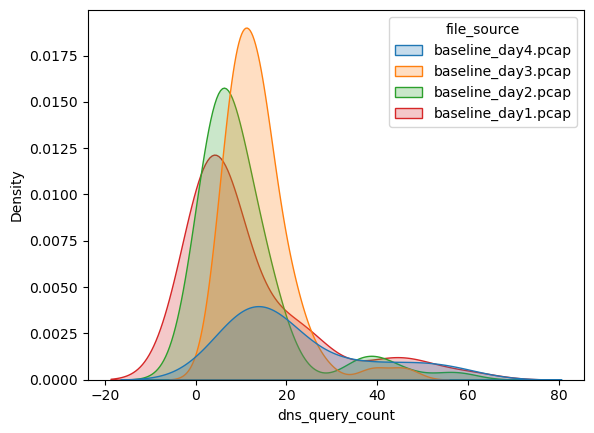

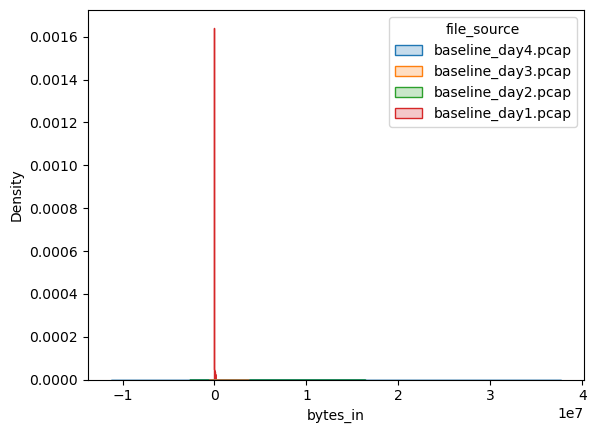

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


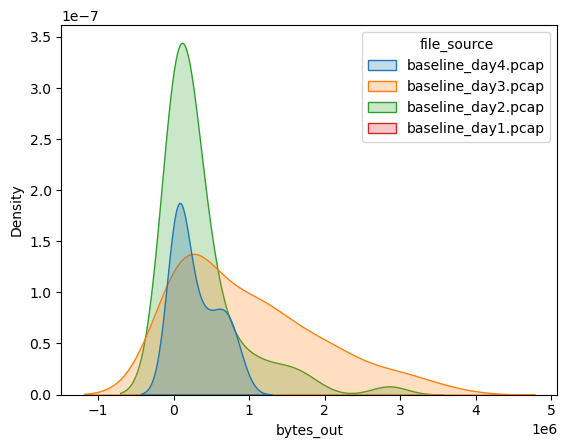

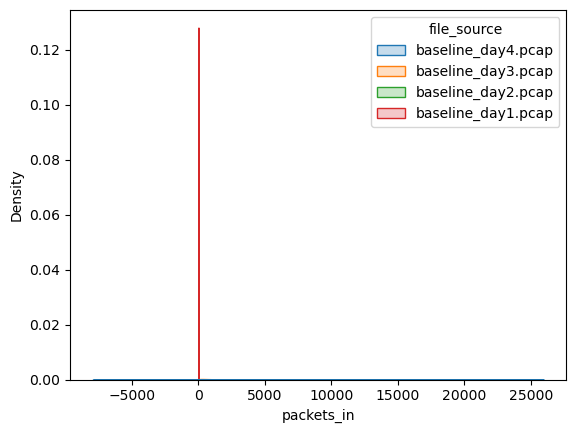

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


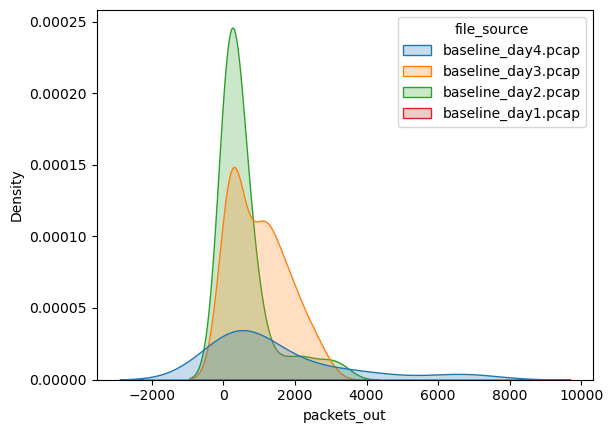

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


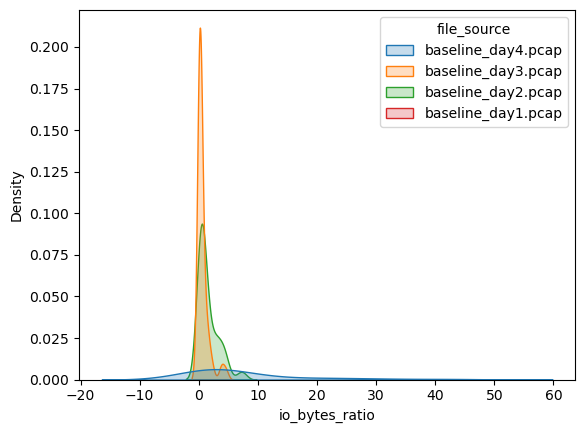

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


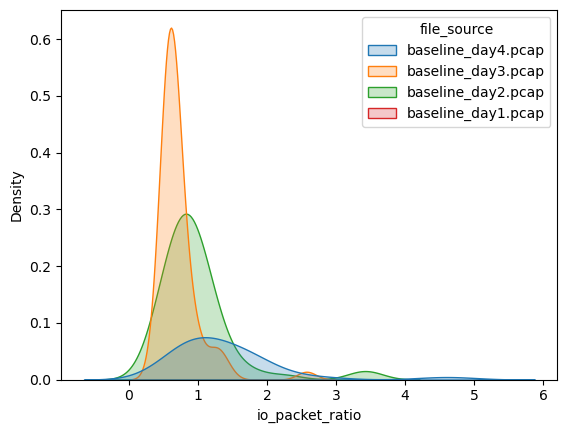

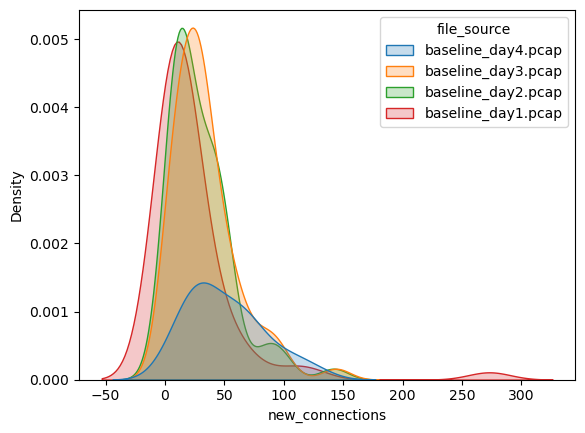

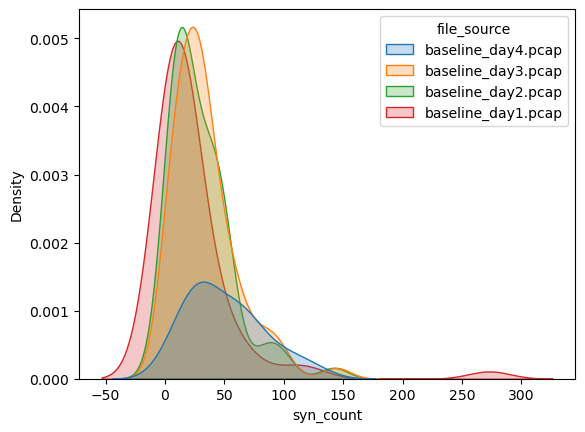

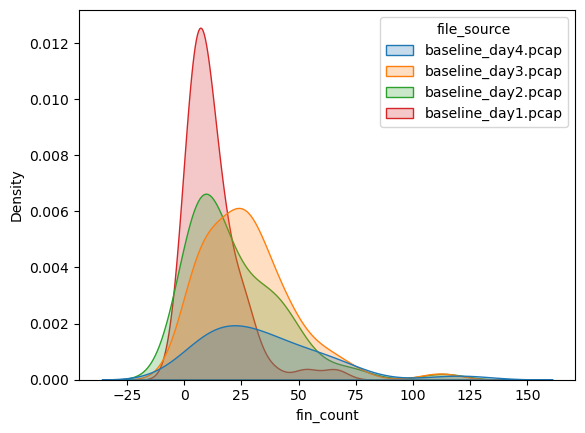

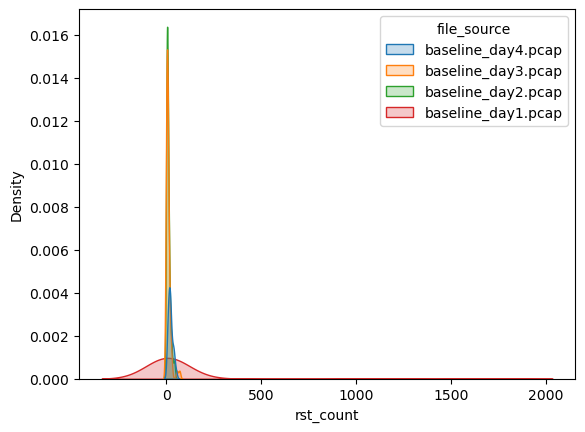

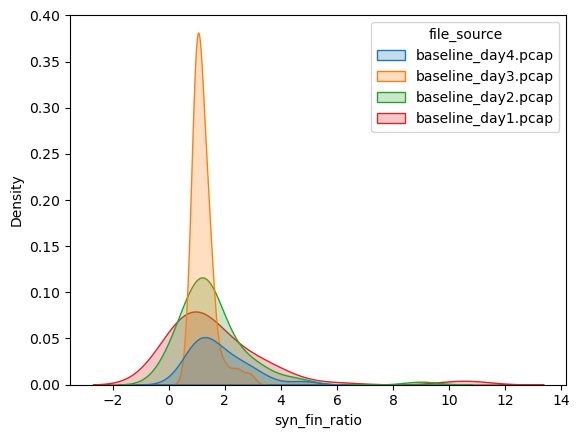

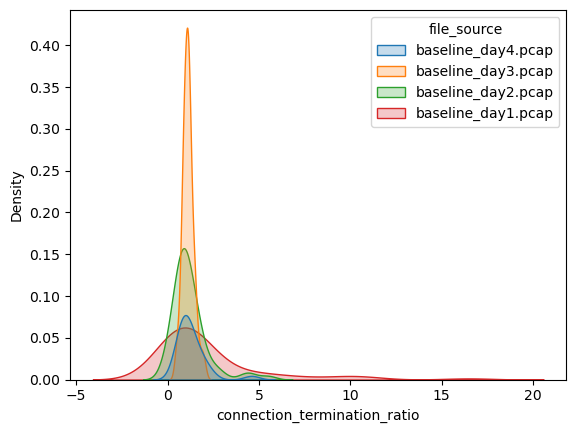

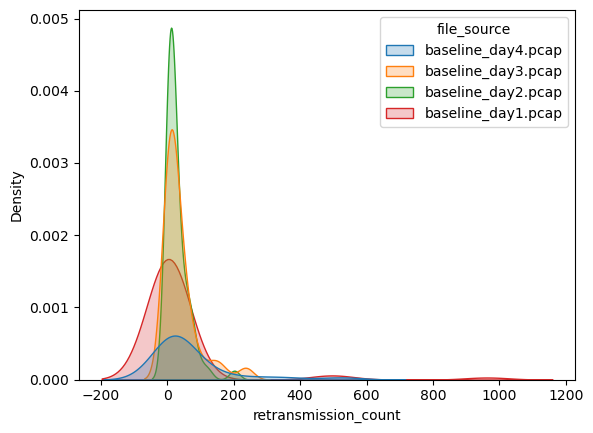

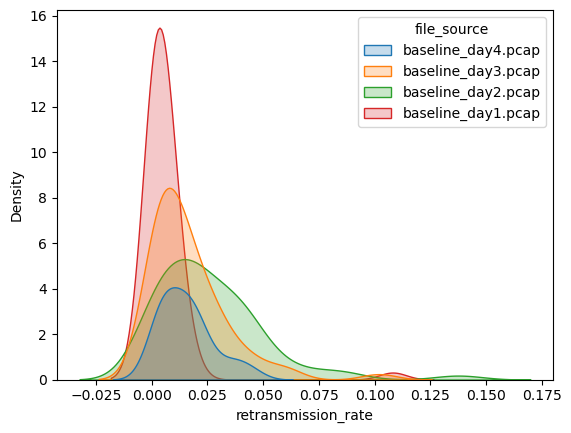

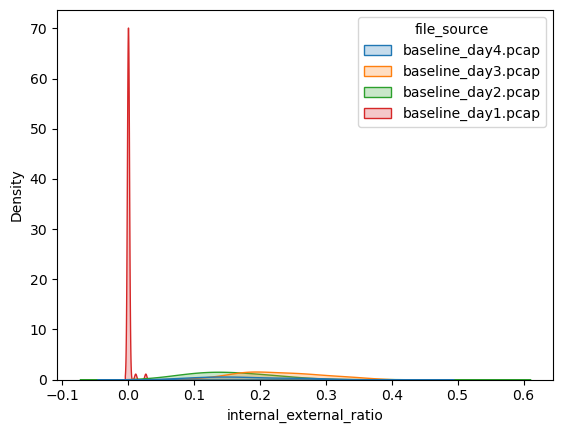

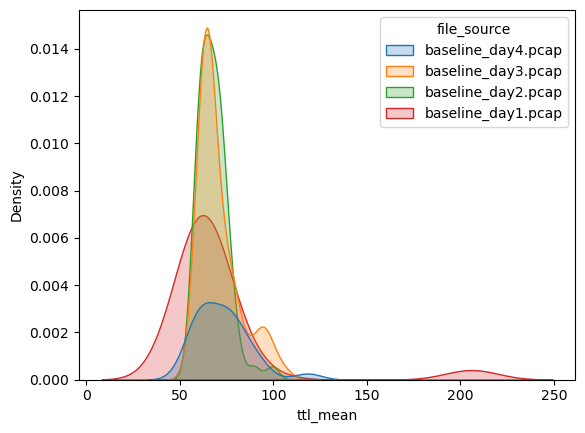

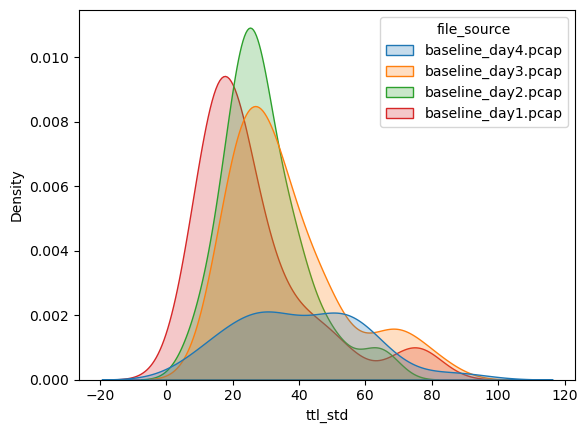

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


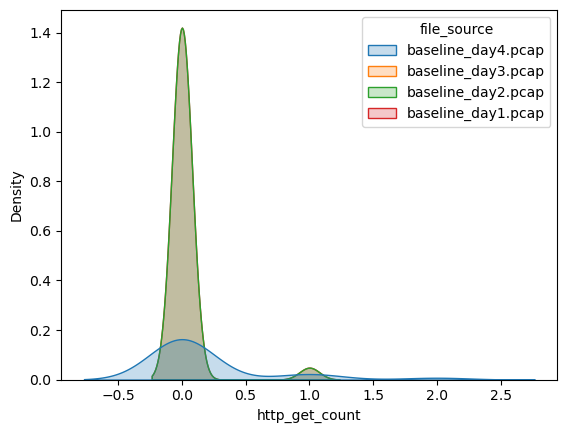

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


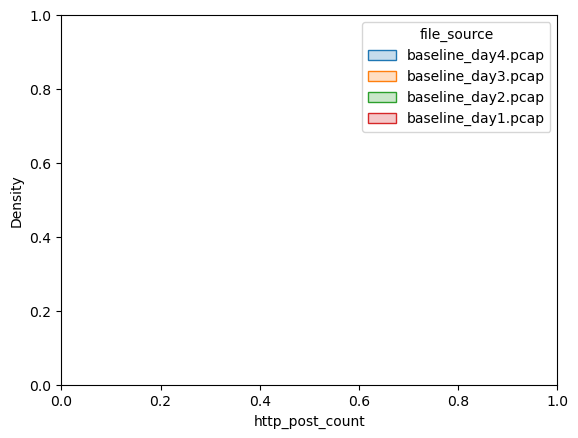

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_9753/2599347580.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="file_source",fill=True)


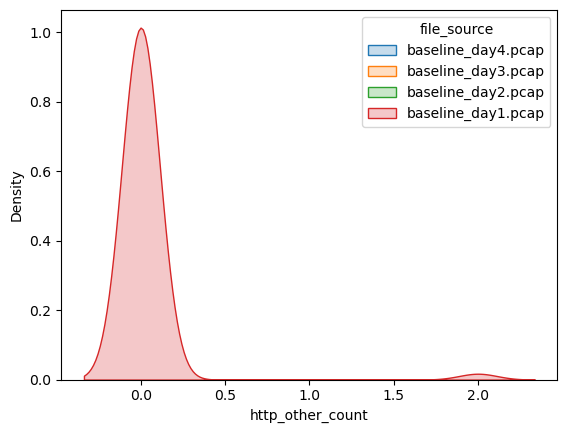

In [16]:
get_stats(adv_df)